# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier,DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, PCA, RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
%matplotlib inline
import datetime
import time
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project Capstone") \
    .getOrCreate()

23/05/07 08:33:43 WARN Utils: Your hostname, nvnhan resolves to a loopback address: 127.0.1.1; using 192.168.2.37 instead (on interface wlp2s0)
23/05/07 08:33:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/07 08:33:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.submitTime', '1683423224401'),
 ('spark.app.id', 'local-1683423226943'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '38983'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
df = spark.read.json("mini_sparkify_event_data.json")

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
df.count()

286500

In [8]:
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

In [9]:
df.count()

286500

In [10]:
df.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [11]:
df.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [12]:
# remove those with an empty string userId
df = df.filter(df["userId"] != "")

In [13]:
df.count()

278154

In [14]:
df_pandas = df.toPandas()
df_pandas

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,Iron Maiden,Logged In,Emilia,F,38,House,258.66404,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,NextSong,1538336771000,500,Murders In The Rue Morgue (1998 Digital Remaster),200,1543622121000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278150,None,Logged In,Emilia,F,39,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",PUT,Logout,1538336771000,500,None,307,1543622122000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278151,None,Logged In,Emilia,F,43,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,Home,1538336771000,500,None,200,1543622248000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011
278152,None,Logged In,Emilia,F,44,House,NaN,paid,"New York-Newark-Jersey City, NY-NJ-PA",GET,About,1538336771000,500,None,200,1543622398000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,300011


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Identify users who have churned by filtering for the Cancellation Confirmation event under the page column.

In [15]:
# check "Cancellation Confirmation" page.
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



From the above section, it can be observed that the cancellation confirmation page is where users are directed to after they confirm their intention to cancel their service. Once again, this is how we determine churn.

In [16]:
# number of users who churned
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").count()

52

Based on the previous section, it is apparent that our dataset contains 52 users who have churned. We can further examine the userids associated with these churned users.

In [17]:
df.select(["userId", "page"]).where(df.page == "Cancellation Confirmation").show()

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
|    87|Cancellation Conf...|
|   122|Cancellation Conf...|
|    12|Cancellation Conf...|
|    58|Cancellation Conf...|
|    73|Cancellation Conf...|
|     3|Cancellation Conf...|
|   106|Cancellation Conf...|
|   103|Cancellation Conf...|
|    28|Cancellation Conf...|
|    54|Cancellation Conf...|
+------+--------------------+
only showing top 20 rows



Next, we will generate a churn flag for users, where a value of 1 will indicate churned users and 0 will indicate non-churned users. This flag will be appended to the dataset as a new column named "churn".

In [18]:
def churn_event(x):
    if x == "Cancellation Confirmation":
        return 1
    else:
        return 0

churn_event_udf = udf(churn_event, IntegerType())

In [19]:
df = df.withColumn("churn", churn_event_udf("page"))

In [20]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [21]:
# Sort records for each user in reverse chronological order so we can cumulatively sum the churn column
windowval = Window.partitionBy("userId").orderBy(col("ts").desc()).rangeBetween(Window.unboundedPreceding, 0)

In [22]:
# Create a column named "churn" which contains the cumulative sum of 1s in the "churn" column over each user's records
df = df.withColumn("churn", Fsum(col("churn")).over(windowval))

In [23]:
# Group the data by churn to get counts of users in each churn category
df_churn = df.select(['userId', 'churn']).dropDuplicates().groupBy('churn').count()

In [24]:
df_churn.show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



### EDA for Users that Stayed vs Users that Churned

In [25]:
# convert to pandas for visualisation
df_churn = df_churn.toPandas()

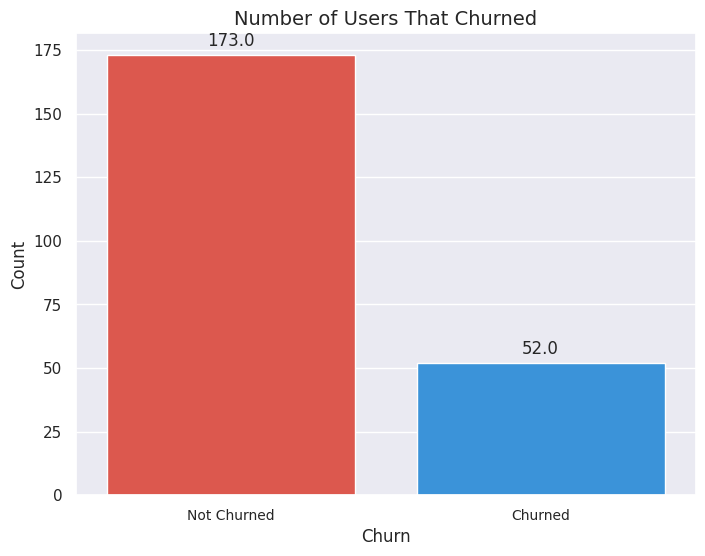

In [26]:
# Plot the number of users that churned
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
ax = sns.barplot(data=df_churn, x='churn', y='count', palette=["#f44336", "#2196f3"])
ax.set_title("Number of Users That Churned", fontsize=14)
ax.set_xlabel("Churn", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_xticklabels(["Not Churned", "Churned"], fontsize=10)
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

In [27]:
# calculate churn rate
total_users = df.select('userId').dropDuplicates().count()
churned_users = df.filter(df.churn == 1).select('userId').dropDuplicates().count()
churn_rate = (churned_users / total_users) * 100
print("Churn rate: {:.2f}%".format(churn_rate))

Churn rate: 23.11%


Looking at the information above, we can observe that out of the total number of users, 173 remained with the service while 52 users churned. This implies that 23% of the users churned. It is worth noting that this indicates an imbalance between the churned and non-churned users in the dataset.

### Length of time: Users that Churned vs. Users that Stayed

In [28]:
# get those customers who churned
df_len = df.filter(df.churn ==1)

In [29]:
# convert to pandas
df_pd = df_len.toPandas()
# drop the nulls
df_pd.length.dropna(inplace=True)

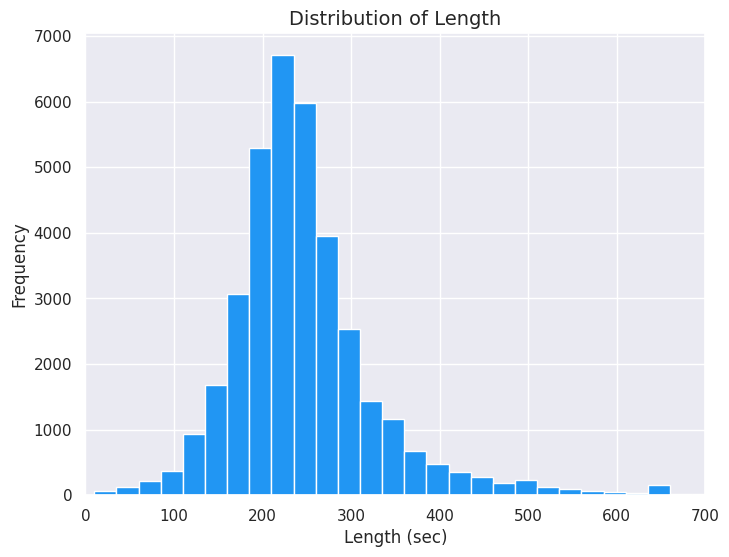

In [30]:
# Plot the distribution of length
plt.figure(figsize=(8,6))
sns.set_style("darkgrid")
bin_edges = np.arange(10, df_pd['length'].max() + 25, 25)
plt.hist(data=df_pd, x='length', bins=bin_edges, color="#2196f3")
plt.xlim(0, 700)
plt.title("Distribution of Length", fontsize=14)
plt.xlabel("Length (sec)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

In [31]:
# users who stayed
df_len_stay = df.filter(df.churn ==0)

In [32]:
# convert to pandas
df_pd = df_len_stay.toPandas()
# drop nulls
df_pd.length.dropna(inplace=True)

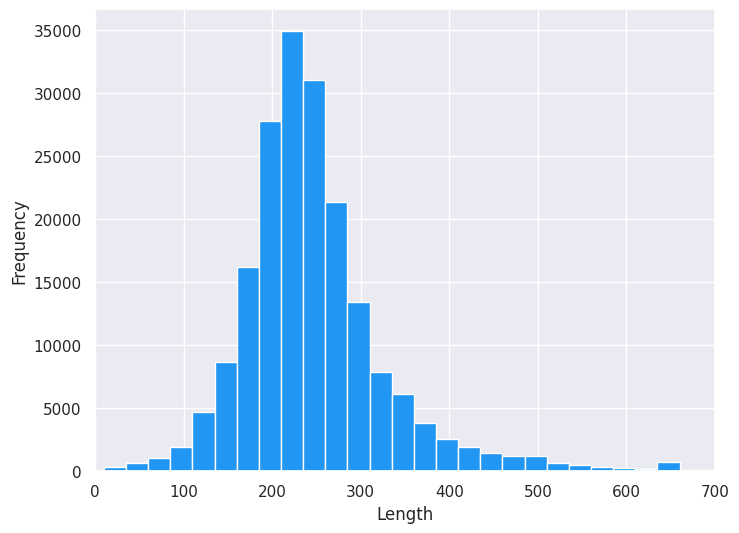

In [33]:
bin_edges = np.arange(10, df_pd['length'].max()+25, 25)
plt.figure(figsize=(8,6))
plt.hist(data=df_pd, x='length', bins=bin_edges, color="#2196f3")
plt.xlim(0,700)
plt.xlabel('Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

Based on the above plots, it is evident that the distribution of length is very similar for both the users who churned and those who stayed. Therefore, this feature may not be very useful for predicting customer churn. To explore further, let's analyze a categorical feature: gender.

### Gender - Users who Churned vs Users who Stayed

In [34]:
# create gender df grouped by churn and gender
df_gender = df.select(['userId', 'churn', 'gender']).dropDuplicates().groupBy('gender', 'churn').count()

In [35]:
df_gender.show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



In [36]:
# convert to pandas for visualisation
df_gender = df_gender.toPandas()

In [37]:
df_gender = df_gender.sort_values('count', ascending = False)

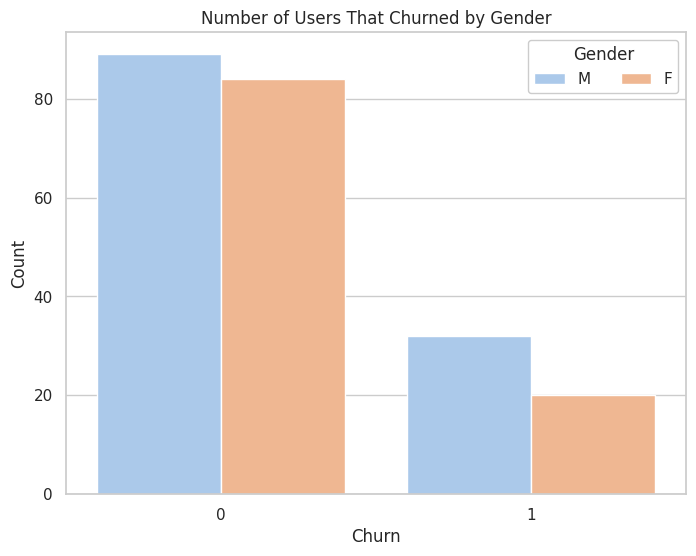

In [38]:
plt.figure(figsize=[8, 6])
sns.set_style('whitegrid')

ax = sns.barplot(data=df_gender, x='churn', y='count', hue='gender', palette='pastel')
ax.set_xlabel('Churn')
ax.set_ylabel('Count')
ax.set_title('Number of Users That Churned by Gender')
ax.legend(loc='upper right', ncol=2, title='Gender', framealpha=1)

plt.show()


In [39]:
# male churn rate
male_data = df_gender[df_gender['gender'] == 'M']
male_churned = male_data[male_data['churn'] == 1]['count'].sum()
total_male = male_data['count'].sum()
male_churn_rate = (male_churned / total_male) * 100
print(f"The male churn rate is {male_churn_rate:.2f}%")

The male churn rate is 26.45%


In [40]:
# Female churn rate
male_data = df_gender[df_gender['gender'] == 'F']
male_churned = male_data[male_data['churn'] == 1]['count'].sum()
total_male = male_data['count'].sum()
male_churn_rate = (male_churned / total_male) * 100
print(f"The male churn rate is {male_churn_rate:.2f}%")

The male churn rate is 19.23%


Based on the seaborn barplot, it appears that the churn rate for male users (26.4%) is higher than that for female users (19.2%). This suggests that male users may be more likely to churn compared to female users in the dataset.

### Users who Churned vs Stayed by Level

In [41]:
# create the level dataframe
df_level = df.select(['userId', 'churn', 'level']).dropDuplicates().groupBy('level','churn').count()

In [42]:
df_level.show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| free|    0|  149|
| paid|    0|  129|
| free|    1|   46|
| paid|    1|   36|
+-----+-----+-----+



In [43]:
# convert to pandas for visualisation
df_level = df_level.toPandas()

/tmp/ipykernel_55681/3343978832.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), fontweight='bold', fontsize=12)


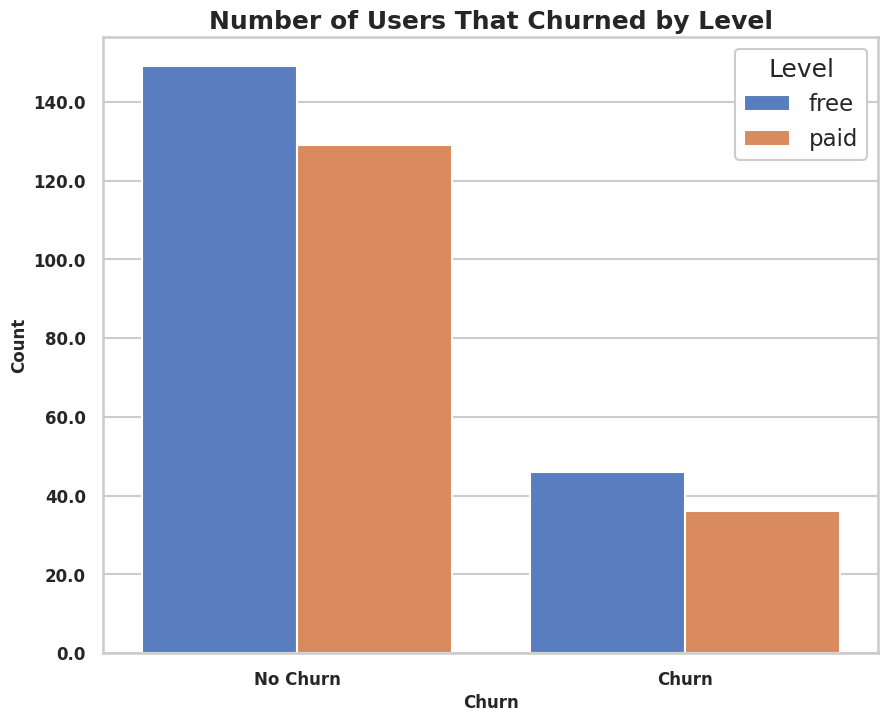

In [44]:
# Set the style and context for the plot
sns.set_style('whitegrid')
sns.set_context('talk')

# Plot the barplot using seaborn
plt.figure(figsize=[10, 8])
ax = sns.barplot(data=df_level, x='churn', y='count', hue='level', palette='muted')
ax.legend(loc='upper right', ncol=1, framealpha=1, title='Level')

# Set the title and labels for the x and y axes
plt.title('Number of Users That Churned by Level', fontweight='bold')
ax.set_xlabel('Churn', fontweight='bold', fontsize=12)
ax.set_ylabel('Count', fontweight='bold', fontsize=12)

# Customize the tick labels and the legend title
ax.set_xticklabels(['No Churn', 'Churn'], fontweight='bold', fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontweight='bold', fontsize=12)
ax.get_legend().set_title('Level')

# Show the plot
plt.show()

In [45]:
free_data = df_level[df_level['level'] == 'free']
free_churned = free_data[free_data['churn'] == 1]['count'].sum()
total_free = free_data['count'].sum()
free_churn_rate = (free_churned / total_free) * 100
print("The churn rate for the free level is {:.2f}%".format(free_churn_rate))

The churn rate for the free level is 23.59%


In [46]:
free_data = df_level[df_level['level'] == 'paid']
free_churned = free_data[free_data['churn'] == 1]['count'].sum()
total_free = free_data['count'].sum()
free_churn_rate = (free_churned / total_free) * 100
print("The churn rate for the paid level is {:.2f}%".format(free_churn_rate))

The churn rate for the paid level is 21.82%


Based on the barplot, we can observe that the proportion of users who churned was slightly higher for the free level (23,6%) compared to the paid level (21,8%), indicating that users who used the service for free were more likely to churn.

### Pages Visited by Those that Churned vs. Those That Stayed

In [47]:
df_page = df.select(['userId', 'churn', 'page']).groupBy('page','churn').count()

In [48]:
df_page.show(20)

+--------------------+-----+-----+
|                page|churn|count|
+--------------------+-----+-----+
|            Settings|    0| 1244|
|         Thumbs Down|    1|  496|
|           Thumbs Up|    1| 1859|
|     Add to Playlist|    1| 1038|
|               Error|    1|   32|
|               About|    1|   56|
|         Thumbs Down|    0| 2050|
|         Roll Advert|    1|  967|
|                Home|    0| 8410|
|Cancellation Conf...|    1|   52|
|               Error|    0|  220|
|              Cancel|    1|   52|
|            Settings|    1|  270|
|          Add Friend|    1|  636|
|             Upgrade|    0|  387|
|           Downgrade|    1|  337|
|              Logout|    1|  553|
|    Submit Downgrade|    1|    9|
|       Save Settings|    0|  252|
|           Thumbs Up|    0|10692|
+--------------------+-----+-----+
only showing top 20 rows



In [49]:
# convert to pandas
df_page = df_page.toPandas()

In [50]:
# create counts for those who churned and those who stayed
churn_count =  df_page[df_page['churn'] == 1].sum() 
stay_count =  df_page[df_page['churn'] == 0].sum()

In [51]:
# calculate the rate of pages visited by those who churned vs. those who stayed
df_page['rate'] = np.where(
    df_page['churn'] == 0, df_page['count']/stay_count['count'], np.where(
    df_page['churn'] == 1, df_page['count']/churn_count['count'],df_page['count']/churn_count['count'])) 

In [52]:
df_page.head(20)

,page,churn,count,rate
0,Settings,0,1244,0.005332
1,Thumbs Down,1,496,0.011056
2,Thumbs Up,1,1859,0.041436
3,Add to Playlist,1,1038,0.023137
4,Error,1,32,0.000713
5,About,1,56,0.001248
6,Thumbs Down,0,2050,0.008787
7,Roll Advert,1,967,0.021554
8,Home,0,8410,0.036050
9,Cancellation Confirmation,1,52,0.001159


Text(0.5, 1.0, 'Rate of Pages Navigated to by Users that Churned vs. Users that Stayed')

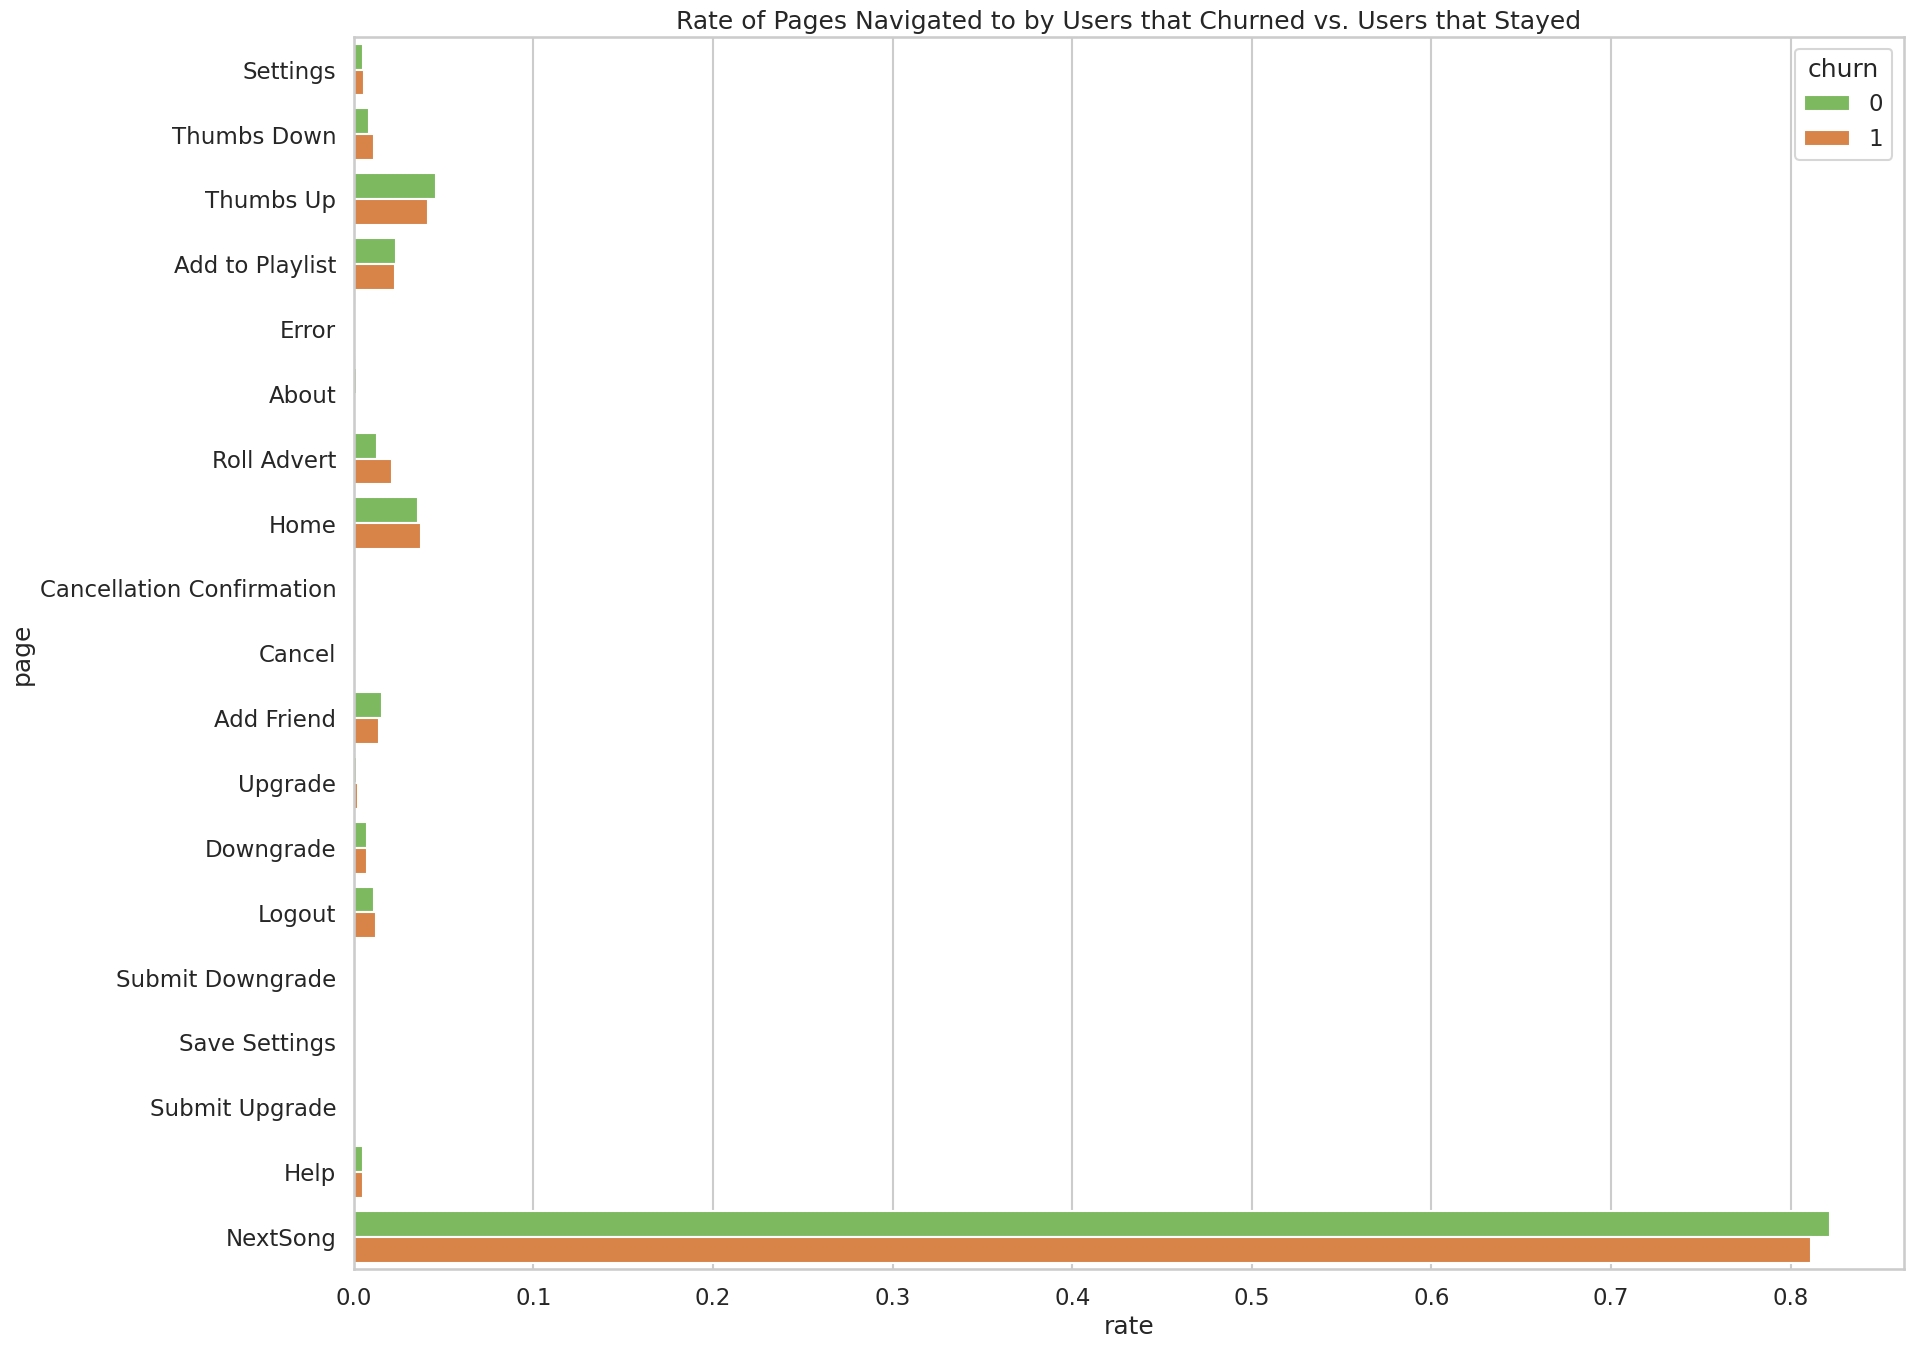

In [53]:
plt.figure(figsize=[20,16])
sns.barplot(data=df_page, x='rate', y='page', hue='churn', palette=['#78C850', '#F08030'])
plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed')

Based on the chart above, it can be observed that the most common action for both users who stayed and those who churned was skipping to the next song. However, churned users were more likely to roll the ad and give thumbs down to songs. In contrast, users who were more likely to stay performed more thumbs up actions, added friends, and added songs to their playlist.

### Calculating Songs per Hour

In [54]:
# get hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [55]:
# create hour column
df = df.withColumn("hour", get_hour(df.ts))

In [56]:
df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='1')

In [57]:
songs_in_hour_stay = df.filter((df.page == "NextSong") & (df.churn == 0)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [58]:
songs_in_hour_stay.show(24)

+----+-----+
|hour|count|
+----+-----+
|   0| 9464|
|   1| 9146|
|   2| 9112|
|   3| 9107|
|   4| 8853|
|   5| 8526|
|   6| 8085|
|   7| 7527|
|   8| 7035|
|   9| 7014|
|  10| 7063|
|  11| 6914|
|  12| 6960|
|  13| 6836|
|  14| 6873|
|  15| 7023|
|  16| 7268|
|  17| 7502|
|  18| 7440|
|  19| 7918|
|  20| 8073|
|  21| 8792|
|  22| 9462|
|  23| 9721|
+----+-----+



In [59]:
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()
songs_in_hour_stay_pd.hour = pd.to_numeric(songs_in_hour_stay_pd.hour)

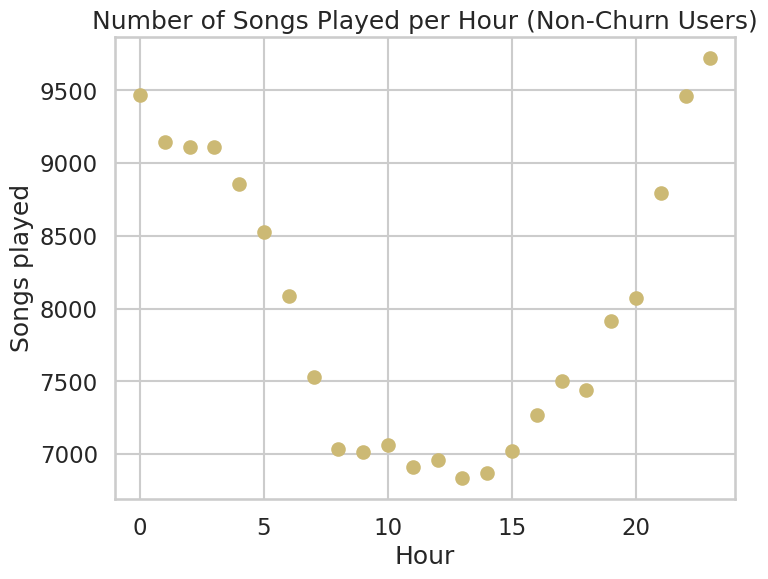

In [60]:
# plot the distribution
plt.figure(figsize=[8, 6])
plt.scatter(songs_in_hour_stay_pd['hour'], songs_in_hour_stay_pd['count'], c='y')
plt.xlim(-1, 24)
plt.xlabel('Hour')
plt.ylabel('Songs played')
plt.title('Number of Songs Played per Hour (Non-Churn Users)')
plt.show()

The above chart shows that there is a peak of songs played between 3pm and 8pm for non-churn users. Now, we will examine the behavior of users who churned using the same process.

In [61]:
songs_in_hour_churned = df.filter((df.page == "NextSong") & (df.churn == 1)).groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [62]:
songs_in_hour_churned.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 1996|
|   1| 1978|
|   2| 1818|
|   3| 1749|
|   4| 1605|
|   5| 1596|
|   6| 1545|
|   7| 1535|
|   8| 1353|
|   9| 1322|
|  10| 1292|
|  11| 1233|
|  12| 1218|
|  13| 1218|
|  14| 1218|
|  15| 1230|
|  16| 1230|
|  17| 1380|
|  18| 1390|
|  19| 1408|
+----+-----+
only showing top 20 rows



In [63]:
songs_in_hour_churned = songs_in_hour_churned.toPandas()
songs_in_hour_churned.hour = pd.to_numeric(songs_in_hour_churned.hour)

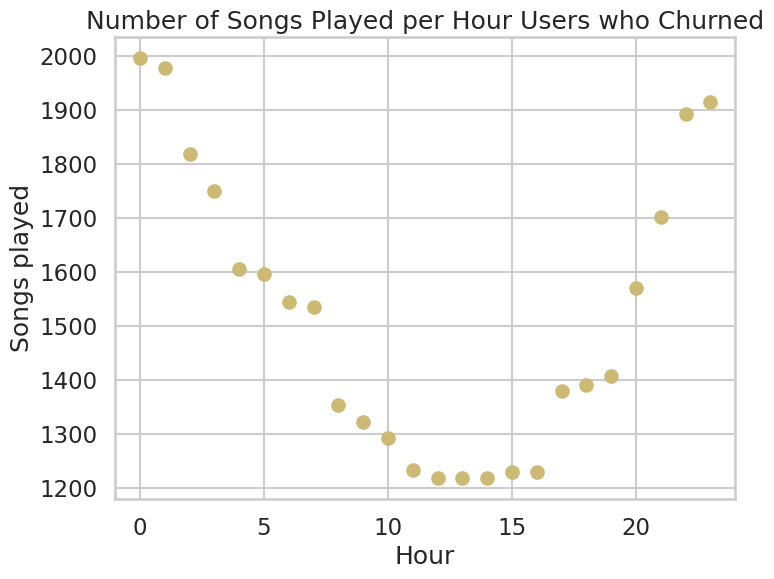

In [64]:
plt.figure(figsize = [8,6])
plt.scatter(songs_in_hour_churned["hour"], songs_in_hour_churned["count"], c='y')
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour Users who Churned");

Looking at the chart, we can observe a similar pattern of song plays per hour among users who churned, with a peak between 3pm and 8pm as well. However, on average, users who churned listened to fewer songs per hour compared to those who stayed.

### Songs Per Session for Users who Churned vs. Those who Stayed

In [65]:
df_songs = df.filter(df.page == "NextSong").dropDuplicates().groupBy('sessionId','churn').count()

In [66]:
df_songs.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0| 93.3369036027264|
|    1|79.81140350877193|
+-----+-----------------+



In [67]:
df_songs = df_songs.groupby('churn').agg({"count":"avg"})

In [68]:
df_songs = df_songs.toPandas()

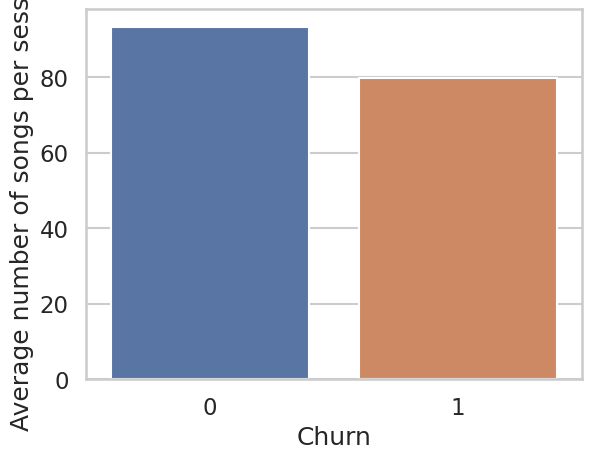

In [69]:
sns.barplot(x="churn", y="avg(count)", data=df_songs)
plt.xlabel("Churn")
plt.ylabel("Average number of songs per session")
plt.show()

Based on the chart, it can be observed that the average number of songs played per session for users who have churned from Sparkify is lower than those who have not churned. In other words, users who have churned from Sparkify actually listened to fewer songs on average per session.

### Unique Artists Played in a Listening Session

In [70]:
df_artists = df.select("artist", "userId", "churn").dropDuplicates().groupby("userId", "churn").count()

In [71]:
df_artists.groupby('churn').agg({"count":"avg"}).show()

+-----+-----------------+
|churn|       avg(count)|
+-----+-----------------+
|    0|750.7803468208092|
|    1|519.6923076923077|
+-----+-----------------+



In [72]:
df_artists = df_artists.toPandas()

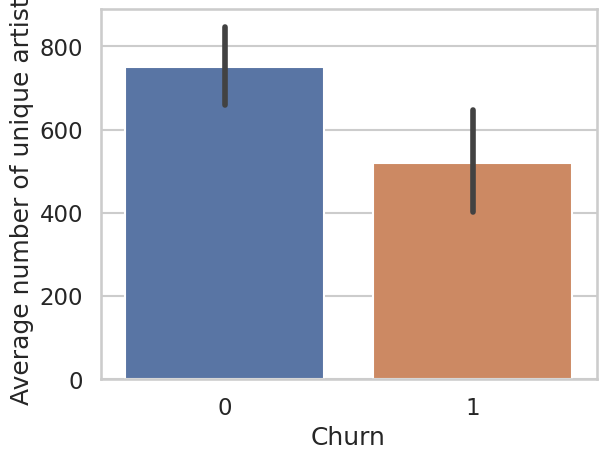

In [73]:
# Draw a barplot
sns.barplot(x="churn", y="count", data=df_artists)

# Set the labels for the x- and y-axis
plt.xlabel("Churn")
plt.ylabel("Average number of unique artists")

# Show the plot
plt.show()

Based on the chart, it is apparent that users who did not churn listened to a larger number of unique artists on average compared to users who churned.

### Location

In [74]:
df.select("location", "userId", "churn").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|     Gainesville, FL| 1229|
|Atlantic City-Ham...| 2176|
|Deltona-Daytona B...|   73|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|   Winston-Salem, NC|  819|
|     Bakersfield, CA| 1775|
|Los Angeles-Long ...|30131|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Phoenix-Mesa-Scot...| 4846|
|Allentown-Bethleh...|  815|
|Miami-Fort Lauder...| 3764|
|           Selma, AL| 2027|
|          Dayton, OH|  259|
|Bridgeport-Stamfo...|  893|
+--------------------+-----+
only showing top 20 rows



In [75]:
get_state = udf(lambda x: x[-2:])
df_state = df.withColumn("state", get_state(df.location))

In [76]:
df_state.take(2)

[Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='1', state='CT'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Darianna', gender='F', itemInSession=33, lastName='Carpenter', length=185.25995, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=187, song='22', status=200, ts=1542823951000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=0, hour='1', state=

In [77]:
df_state = df_state.select("state", "userId", "churn").dropDuplicates().groupby("state", "churn").count()

In [78]:
df_state_pd = df_state.toPandas()

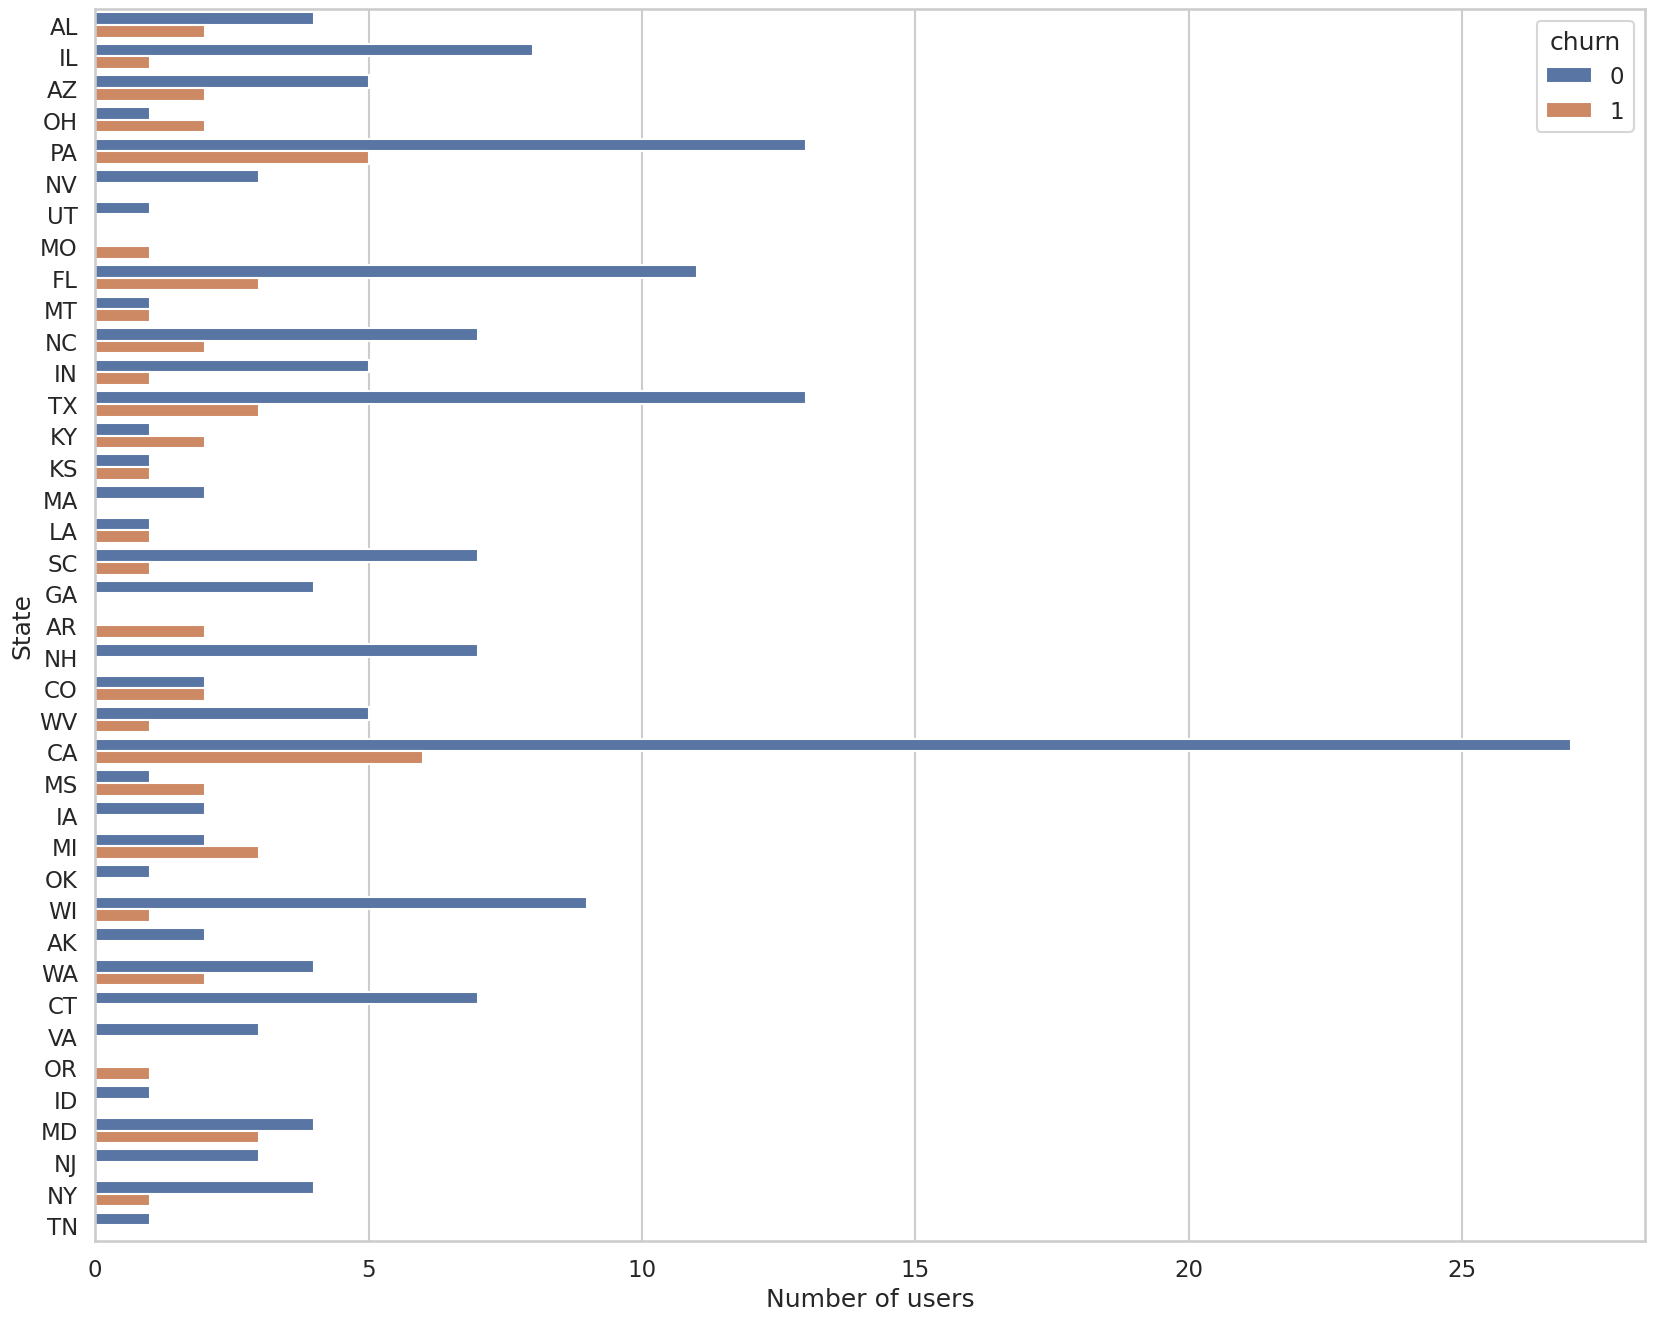

In [79]:
# plot 
plt.figure(figsize=[20,16])
sns.barplot(data = df_state_pd, x = 'count', y = 'state', hue = 'churn')
plt.xlabel("Number of users")
plt.ylabel("State")

# Show the plot
plt.show()

The majority of users were located in California. However, a higher proportion of users from the states of Michigan, Kentucky, and Ohio churned compared to those who stayed. Although it may be challenging to derive a useful feature from this column for modeling purposes, we can move on to analyzing another column in our dataset - operating systems and browsers.

### Analysis of UserAgent - Operating Systems and Browsers

In [80]:
df_opsys = df.select("userId", "userAgent", "churn").dropDuplicates(['userId'])

In [81]:
df_opsys.show()

+------+--------------------+-----+
|userId|           userAgent|churn|
+------+--------------------+-----+
|   100|Mozilla/5.0 (Wind...|    0|
|100005|"Mozilla/5.0 (Mac...|    1|
|100006|"Mozilla/5.0 (Win...|    1|
|100007|"Mozilla/5.0 (Win...|    1|
|100008|Mozilla/5.0 (Maci...|    0|
|100009|"Mozilla/5.0 (Win...|    1|
|100010|"Mozilla/5.0 (iPh...|    0|
|100014|"Mozilla/5.0 (Win...|    1|
|100021|"Mozilla/5.0 (Mac...|    1|
|100022|Mozilla/5.0 (Maci...|    1|
|100025|"Mozilla/5.0 (Mac...|    1|
|   101|Mozilla/5.0 (Wind...|    1|
|   107|Mozilla/5.0 (Wind...|    0|
|    11|Mozilla/5.0 (Wind...|    0|
|   110|"Mozilla/5.0 (Mac...|    0|
|   112|Mozilla/5.0 (Wind...|    0|
|   113|"Mozilla/5.0 (Mac...|    0|
|   118|"Mozilla/5.0 (Win...|    0|
|   120|"Mozilla/5.0 (Mac...|    0|
|   124|"Mozilla/5.0 (Mac...|    0|
+------+--------------------+-----+
only showing top 20 rows



In [82]:
df_opsys = df_opsys.toPandas()
os_list = ["Windows", "Mac", "Linux", "iPhone", "iPad"]
df_opsys['os'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(os_list)))

In [83]:
df_opsys

,userId,userAgent,churn,os
0,100,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) G...,0,Windows
1,100005,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",1,Mac
2,100006,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows
3,100007,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",1,Windows
4,100008,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; r...,0,Mac
...,...,...,...,...
220,92,"""Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...",0,iPad
221,93,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT...,0,Windows
222,94,"""Mozilla/5.0 (Windows NT 6.2; WOW64) AppleWebK...",0,Windows
223,95,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,0,Mac


In [84]:
os_order = df_opsys.os.value_counts().index

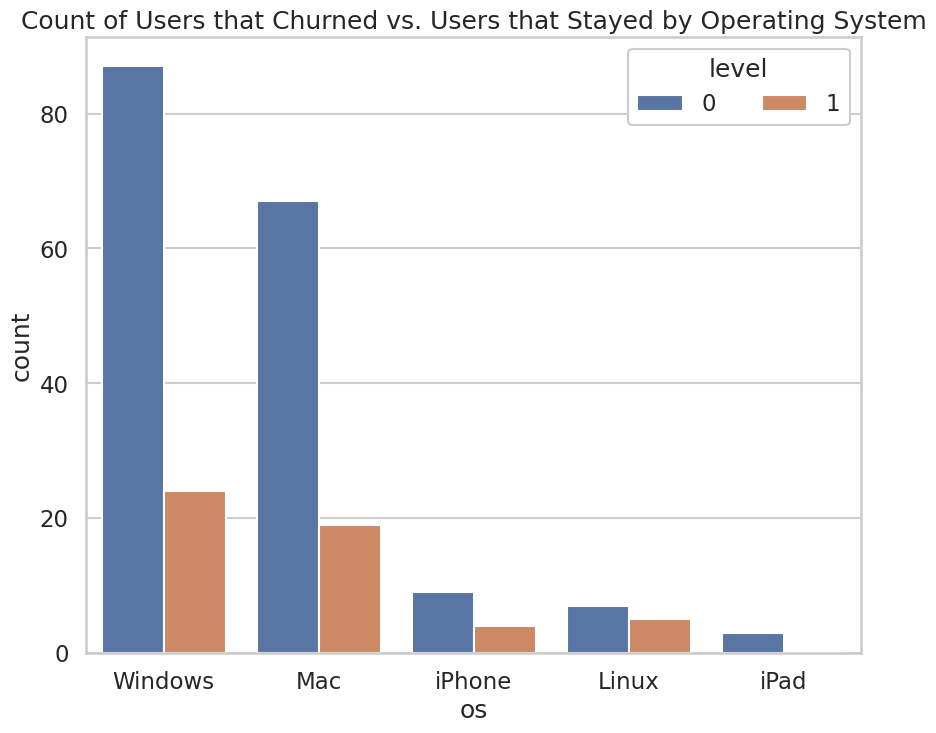

In [85]:
plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'os', hue ='churn', order = os_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Operating System')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level')

Windows was the most used. Linux users have the highest rate of churn. It is very few customers that this has affected therefore this won't be used in our model.

In [86]:
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]
df_opsys['browser'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))
df_opsys.browser.value_counts()

browser
Chrome     117
Firefox     50
Safari      46
Trident     12
Name: count, dtype: int64

In [87]:
df_opsys['browser'].replace({"Trident":"Internet Explorer"}, inplace = True)
browser_order = df_opsys.browser.value_counts().index

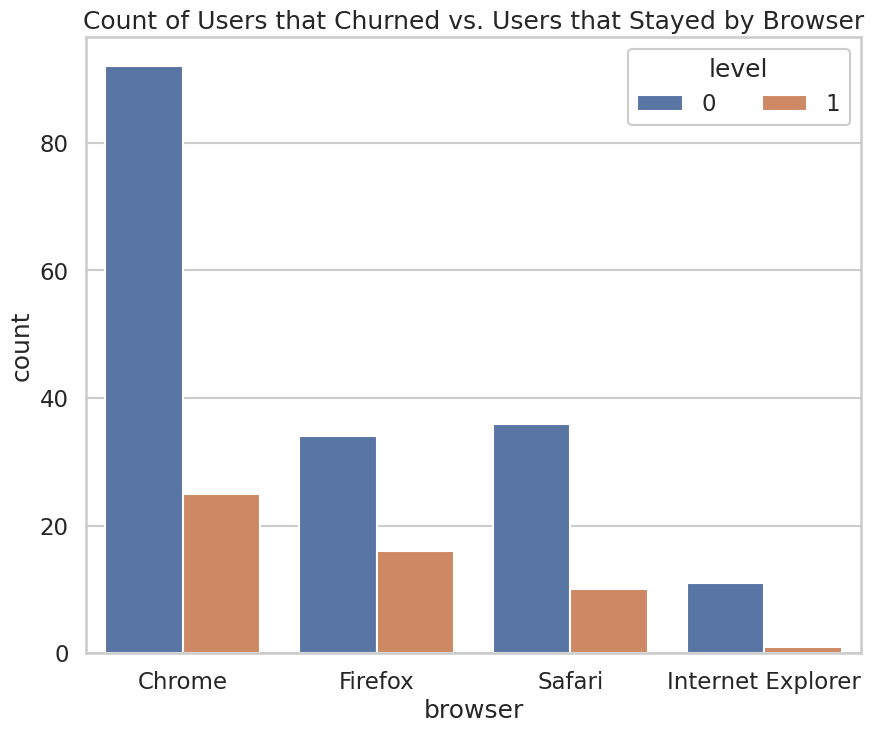

In [88]:
plt.figure(figsize=[10,8])
sns.countplot(data = df_opsys, x = 'browser', hue ='churn', order = browser_order)
plt.title('Count of Users that Churned vs. Users that Stayed by Browser')
plt.legend(loc = 1, ncol = 2, framealpha =1, title = 'level');

Based on the plot, we can see that Chrome was the most commonly used browser among the users in our dataset. Users who used Firefox were more likely to churn than users who used other browsers, while Internet Explorer had the fewest number of churned users. However, overall, there doesn't seem to be a clear relationship between the browsers used by users and their likelihood to churn. Therefore, we will not consider this information when building our model.

### Days Since Registration

In [89]:
df_days = df.select(['userId', 'registration', 'ts', 'churn']).dropDuplicates().sort('userId')

In [90]:
w = Window.partitionBy("userId").orderBy(desc("ts"))

In [91]:
df_days = df_days.withColumn("Rank", dense_rank().over(w))

In [92]:
df_days.show()

+------+-------------+-------------+-----+----+
|userId| registration|           ts|churn|Rank|
+------+-------------+-------------+-----+----+
|    10|1538159495000|1542631788000|    0|   1|
|    10|1538159495000|1542631753000|    0|   2|
|    10|1538159495000|1542631690000|    0|   3|
|    10|1538159495000|1542631518000|    0|   4|
|    10|1538159495000|1542631517000|    0|   5|
|    10|1538159495000|1542631090000|    0|   6|
|    10|1538159495000|1542630866000|    0|   7|
|    10|1538159495000|1542630637000|    0|   8|
|    10|1538159495000|1542630407000|    0|   9|
|    10|1538159495000|1542630394000|    0|  10|
|    10|1538159495000|1542630248000|    0|  11|
|    10|1538159495000|1542630247000|    0|  12|
|    10|1538159495000|1542630029000|    0|  13|
|    10|1538159495000|1542629861000|    0|  14|
|    10|1538159495000|1542629636000|    0|  15|
|    10|1538159495000|1542629464000|    0|  16|
|    10|1538159495000|1542629238000|    0|  17|
|    10|1538159495000|1542629029000|    

In [93]:
df_days = df_days.filter(df_days.Rank == 1).drop(df_days.Rank)

In [94]:
df_days.show()

+------+-------------+-------------+-----+
|userId| registration|           ts|churn|
+------+-------------+-------------+-----+
|    10|1538159495000|1542631788000|    0|
|   100|1537982255000|1543587349000|    0|
|100001|1534627466000|1538498205000|    1|
|100002|1529934689000|1543799476000|    0|
|100003|1537309344000|1539274781000|    1|
|100004|1528560242000|1543459065000|    0|
|100005|1532610926000|1539971825000|    1|
|100006|1537964483000|1538753070000|    1|
|100007|1533522419000|1543491909000|    1|
|100008|1537440271000|1543335219000|    0|
|100009|1537376437000|1540611104000|    1|
|100010|1538016340000|1542823952000|    0|
|100011|1537970819000|1538417085000|    1|
|100012|1537381154000|1541100900000|    1|
|100013|1537367773000|1541184816000|    1|
|100014|1535389443000|1542740649000|    1|
|100015|1537208989000|1543073753000|    1|
|100016|1536854322000|1543335647000|    0|
|100017|1533247234000|1540062847000|    1|
|100018|1533812833000|1543378360000|    0|
+------+---

In [95]:
df_days = df_days.withColumn("delta_days", (df_days['ts']) - (df_days['registration']))

In [96]:
df_days.show()

+------+-------------+-------------+-----+-----------+
|userId| registration|           ts|churn| delta_days|
+------+-------------+-------------+-----+-----------+
|    10|1538159495000|1542631788000|    0| 4472293000|
|   100|1537982255000|1543587349000|    0| 5605094000|
|100001|1534627466000|1538498205000|    1| 3870739000|
|100002|1529934689000|1543799476000|    0|13864787000|
|100003|1537309344000|1539274781000|    1| 1965437000|
|100004|1528560242000|1543459065000|    0|14898823000|
|100005|1532610926000|1539971825000|    1| 7360899000|
|100006|1537964483000|1538753070000|    1|  788587000|
|100007|1533522419000|1543491909000|    1| 9969490000|
|100008|1537440271000|1543335219000|    0| 5894948000|
|100009|1537376437000|1540611104000|    1| 3234667000|
|100010|1538016340000|1542823952000|    0| 4807612000|
|100011|1537970819000|1538417085000|    1|  446266000|
|100012|1537381154000|1541100900000|    1| 3719746000|
|100013|1537367773000|1541184816000|    1| 3817043000|
|100014|15

In [97]:
df_days = df_days.withColumn('days',(df_days['delta_days']/1000/3600/24))
df_days.show()

+------+-------------+-------------+-----+-----------+------------------+
|userId| registration|           ts|churn| delta_days|              days|
+------+-------------+-------------+-----+-----------+------------------+
|    10|1538159495000|1542631788000|    0| 4472293000| 51.76265046296297|
|   100|1537982255000|1543587349000|    0| 5605094000| 64.87377314814815|
|100001|1534627466000|1538498205000|    1| 3870739000| 44.80021990740741|
|100002|1529934689000|1543799476000|    0|13864787000|160.47207175925925|
|100003|1537309344000|1539274781000|    1| 1965437000|22.748113425925926|
|100004|1528560242000|1543459065000|    0|14898823000|172.44008101851853|
|100005|1532610926000|1539971825000|    1| 7360899000| 85.19559027777778|
|100006|1537964483000|1538753070000|    1|  788587000| 9.127164351851851|
|100007|1533522419000|1543491909000|    1| 9969490000|115.38761574074074|
|100008|1537440271000|1543335219000|    0| 5894948000| 68.22856481481482|
|100009|1537376437000|1540611104000|  

In [98]:
df_days_pd = df_days.toPandas()

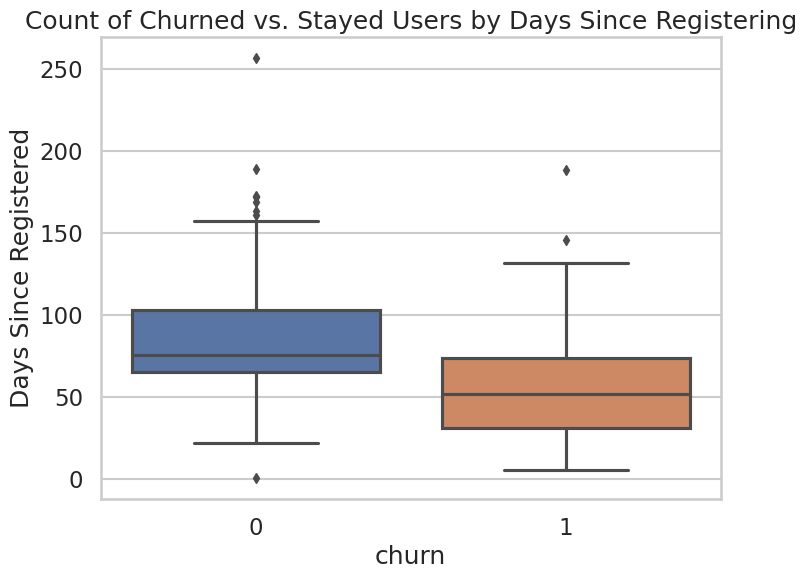

In [99]:
# plot boxplot
plt.figure(figsize=[8,6])
sns.boxplot(data = df_days_pd, x = 'churn', y ='days')
plt.title('Count of Churned vs. Stayed Users by Days Since Registering')
plt.ylabel("Days Since Registered");

From our analysis, we can observe that, on average, users who had been registered with Sparkify for a longer period of time were less likely to churn. On the other hand, users who had registered more recently were more likely to churn. This suggests that the length of time a user has been with Sparkify is a significant predictor of churn and could be a useful feature for our model.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

After completing the EDA, we can now proceed to create the features that appear to be most promising for training our model. These features include:

Categorical:

- Gender
- Subscription level

Numerical:

- Number of songs played per session
- Number of times the user clicked the "roll ads" button
- Number of times the user clicked the "thumbs down" button
- Number of times the user clicked the "thumbs up" button
- Number of friends added
- Number of songs added to the playlist
- Number of different artists listened to on Sparkify
- Number of days since the user registered

We will also include a churn label and combine all these features into a single dataframe where each row corresponds to a unique user. After dropping the userId column, this dataframe can be transformed into a vectorized, standardized format for use with machine learning algorithms.

In [100]:
#Gender
gender_f1 = df.select(['userId', 'gender']).dropDuplicates()
gender_f1 = gender_f1.withColumn('gender', when(col('gender') == 'F', 1).otherwise(0))

In [101]:
gender_f1.count()

225

In [102]:
gender_f1.show(20)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    39|     1|
|    40|     1|
|    94|     1|
|    35|     1|
|    75|     1|
|   100|     0|
|    25|     1|
|    92|     1|
|    52|     1|
|   110|     0|
|    33|     0|
|    42|     1|
|    67|     0|
|    77|     1|
|   136|     1|
|    99|     1|
|   114|     0|
+------+------+
only showing top 20 rows



In [103]:
#Level
df2 = df.select(['userId', 'level', 'ts']).dropDuplicates().sort('userId')
w = Window.partitionBy("userId").orderBy(desc("ts"))
df2 = df2.withColumn("Rank", dense_rank().over(w))


In [104]:
df2.show()

+------+-----+-------------+----+
|userId|level|           ts|Rank|
+------+-----+-------------+----+
|    10| paid|1542631788000|   1|
|    10| paid|1542631753000|   2|
|    10| paid|1542631690000|   3|
|    10| paid|1542631518000|   4|
|    10| paid|1542631517000|   5|
|    10| paid|1542631090000|   6|
|    10| paid|1542630866000|   7|
|    10| paid|1542630637000|   8|
|    10| paid|1542630407000|   9|
|    10| paid|1542630394000|  10|
|    10| paid|1542630248000|  11|
|    10| paid|1542630247000|  12|
|    10| paid|1542630029000|  13|
|    10| paid|1542629861000|  14|
|    10| paid|1542629636000|  15|
|    10| paid|1542629464000|  16|
|    10| paid|1542629238000|  17|
|    10| paid|1542629029000|  18|
|    10| paid|1542629028000|  19|
|    10| paid|1542628798000|  20|
+------+-----+-------------+----+
only showing top 20 rows



In [105]:
level_f2 = df2.filter(df2.Rank == 1).drop(df2.Rank)
level_f2 = level_f2.drop('ts')
level_f2 = level_f2.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))
level_f2.count()

225

In [106]:
level_f2.show(20)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    0|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    0|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    0|
|100018|    0|
+------+-----+
only showing top 20 rows



In [107]:
#Number of songs played per session
song_f3 = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count()
df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().show(2)

+------+---------+-----+
|userId|sessionId|count|
+------+---------+-----+
|    92|      358|   57|
|    42|      433|   16|
+------+---------+-----+
only showing top 2 rows



In [108]:
song_f3 = song_f3.groupby('userId').agg({"count":"avg"})
song_f3 = song_f3.withColumnRenamed("avg(count)", "avg_song")


In [109]:
song_f3.count()

225

In [110]:
song_f3.show(2)

+------+------------------+
|userId|          avg_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
+------+------------------+
only showing top 2 rows



In [111]:
# Number of times the user clicked the "roll ads" button
rollad_f4 = df.select(["userId", "page"])
rollad_event = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())
rollad_f4 = rollad_f4.withColumn("rollad", rollad_event("page"))
rollad_f4 = rollad_f4.groupby('userId').sum("rollad")
rollad_f4 = rollad_f4.withColumnRenamed("sum(rollad)", "roll_ad")

In [112]:
rollad_f4.count()

225

In [113]:
rollad_f4.show(2)

+------+-------+
|userId|roll_ad|
+------+-------+
|    51|      0|
|   124|      4|
+------+-------+
only showing top 2 rows



In [114]:
# Number of times the user clicked the "thumbs down" button
thumbdown_f5 = df.select(["userId", "page"])
thumddown_event = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
thumbdown_f5 = thumbdown_f5.withColumn("Thumbs Down", thumddown_event("page"))
thumbdown_f5 = thumbdown_f5.groupby('userId').sum("Thumbs Down")
thumbdown_f5 = thumbdown_f5.withColumnRenamed("sum(Thumbs Down)", "thumbs_down")

In [115]:
thumbdown_f5.count()

225

In [116]:
thumbdown_f5.show(2)

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|    51|         21|
|   124|         41|
+------+-----------+
only showing top 2 rows



In [117]:
# Number of times the user clicked the "thumbs up" button
thumbup_f6 = df.select(["userId", "page"])
thumbup_event = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
thumbup_f6 = thumbup_f6.withColumn("Thumbs Up", thumbup_event("page"))
thumbup_f6 = thumbup_f6.groupby('userId').sum("Thumbs Up")
thumbup_f6 = thumbup_f6.withColumnRenamed("sum(Thumbs Up)", "thumbs_up")

In [118]:
thumbup_f6.count()

225

In [119]:
thumbup_f6.show(2)

+------+---------+
|userId|thumbs_up|
+------+---------+
|    51|      100|
|   124|      171|
+------+---------+
only showing top 2 rows



In [120]:
# Number of friends added
friend_f7 = df.select(["userId", "page"])
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
friend_f7 = friend_f7.withColumn("add_friend", add_friend("page"))
friend_f7 = friend_f7.groupby('userId').sum("add_friend")
friend_f7 = friend_f7.withColumnRenamed("sum(add_friend)", "add_friend")

In [121]:
friend_f7.count()

225

In [122]:
friend_f7.show(2)

+------+----------+
|userId|add_friend|
+------+----------+
|    51|        28|
|   124|        74|
+------+----------+
only showing top 2 rows



In [123]:
# Number of songs added to the playlist
playlist_f8 = df.select(["userId", "page"])
add_playlist = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
playlist_f8 = playlist_f8.withColumn("Playlist", add_playlist("page"))
playlist_f8 = playlist_f8.groupby('userId').sum("Playlist")
playlist_f8 = playlist_f8.withColumnRenamed("sum(Playlist)", "playlist")

In [124]:
playlist_f8.count()

225

In [125]:
playlist_f8.show(2)

+------+--------+
|userId|playlist|
+------+--------+
|    51|      52|
|   124|     118|
+------+--------+
only showing top 2 rows



In [126]:
#Number of different artists listened to on Sparkify
artists_f9 = df.select("userId", "artist").dropDuplicates().groupby("userId").count()
artists_f9 = artists_f9.withColumnRenamed("count", "num_artists")

In [127]:
artists_f9.count()

225

In [128]:
artists_f9.show(2)

+------+-----------+
|userId|num_artists|
+------+-----------+
|100010|        253|
|200002|        340|
+------+-----------+
only showing top 2 rows



In [129]:
# Number of days since the user registered
days_f10 = df_days.drop('registration', 'ts', 'churn', 'delta_days')

In [130]:
days_f10.count()

225

In [131]:
days_f10.show()

+------+------------------+
|userId|              days|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



In [132]:
#Label
label = df.select("userId", "churn").dropDuplicates().groupby("userId", "churn").count()
label = label.drop('count')

In [133]:
label.count()

225

In [134]:
label = label.withColumnRenamed("churn", "label")

In [135]:
label.show()

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
|100009|    1|
|100010|    0|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    1|
|100018|    0|
+------+-----+
only showing top 20 rows



In [136]:
feature_df = gender_f1.join(level_f2, ["userId"]).join(song_f3, ["userId"]).join(rollad_f4, ["userId"]).join(thumbdown_f5, ["userId"]).join(thumbup_f6, ["userId"]).join(friend_f7, ["userId"]).join(playlist_f8, ["userId"]).join(artists_f9, ["userId"]).join(days_f10, ["userId"]).join(label, ["userId"])

In [137]:
feature_df.show()

+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|userId|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|    10|     0|    1|112.16666666666667|      1|          4|       37|        12|       9|        566| 51.76265046296297|    0|
|   100|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61|       1706| 64.87377314814815|    0|
|100001|     1|    0|             33.25|     14|          2|        8|         2|       3|        126| 44.80021990740741|    1|
|100002|     1|    1|             48.75|      3|          0|        5|         1|       5|        185|160.47207175925925|    0|
|100003|     1|    0|              25.5|      9|          0|        3|         0|       2|         51|22

In [138]:
feature_df = feature_df.drop('userId')
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+
|     0|    1|112.16666666666667|      1|          4|       37|        12|       9|        566| 51.76265046296297|    0|
|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61|       1706| 64.87377314814815|    0|
|     1|    0|             33.25|     14|          2|        8|         2|       3|        126| 44.80021990740741|    1|
|     1|    1|             48.75|      3|          0|        5|         1|       5|        185|160.47207175925925|    0|
|     1|    0|              25.5|      9|          0|        3|         0|       2|         51|22.748113425925926|    1|
|     1|    1|              47.1

In [139]:
feature_df.printSchema()

root
 |-- gender: integer (nullable = false)
 |-- level: integer (nullable = false)
 |-- avg_song: double (nullable = true)
 |-- roll_ad: long (nullable = true)
 |-- thumbs_down: long (nullable = true)
 |-- thumbs_up: long (nullable = true)
 |-- add_friend: long (nullable = true)
 |-- playlist: long (nullable = true)
 |-- num_artists: long (nullable = false)
 |-- days: double (nullable = true)
 |-- label: long (nullable = true)



In [140]:
# Vector Assembler
assembler = VectorAssembler(inputCols = ["gender", "level", "avg_song", "roll_ad", "thumbs_down", "thumbs_up", "add_friend", "playlist", "num_artists", "days"], outputCol = "vec_features")
feature_df = assembler.transform(feature_df)

In [141]:
feature_df.show()

+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+--------------------+
|gender|level|          avg_song|roll_ad|thumbs_down|thumbs_up|add_friend|playlist|num_artists|              days|label|        vec_features|
+------+-----+------------------+-------+-----------+---------+----------+--------+-----------+------------------+-----+--------------------+
|     0|    1|112.16666666666667|      1|          4|       37|        12|       9|        566| 51.76265046296297|    0|[0.0,1.0,112.1666...|
|     0|    1| 78.88235294117646|     25|         27|      148|        49|      61|       1706| 64.87377314814815|    0|[0.0,1.0,78.88235...|
|     1|    0|             33.25|     14|          2|        8|         2|       3|        126| 44.80021990740741|    1|[1.0,0.0,33.25,14...|
|     1|    1|             48.75|      3|          0|        5|         1|       5|        185|160.47207175925925|    0|[1.0,1.0,48.75,3....|
|     

In [142]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [143]:
scaler_model = scaler.fit(feature_df)

In [144]:
feature_df = scaler_model.transform(feature_df)

In [145]:
feature_df.head(2)

[Row(gender=0, level=1, avg_song=112.16666666666667, roll_ad=1, thumbs_down=4, thumbs_up=37, add_friend=12, playlist=9, num_artists=566, days=51.76265046296297, label=0, vec_features=DenseVector([0.0, 1.0, 112.1667, 1.0, 4.0, 37.0, 12.0, 9.0, 566.0, 51.7627]), features=DenseVector([0.0, 2.0844, 2.6321, 0.0464, 0.3059, 0.5651, 0.583, 0.2751, 0.9372, 1.3744])),
 Row(gender=0, level=1, avg_song=78.88235294117646, roll_ad=25, thumbs_down=27, thumbs_up=148, add_friend=49, playlist=61, num_artists=1706, days=64.87377314814815, label=0, vec_features=DenseVector([0.0, 1.0, 78.8824, 25.0, 27.0, 148.0, 49.0, 61.0, 1706.0, 64.8738]), features=DenseVector([0.0, 2.0844, 1.851, 1.1601, 2.0646, 2.2603, 2.3808, 1.8645, 2.8247, 1.7226]))]

# Modeling
We will split the data into training, validation, and testing sets using an 70-20-10 split. We will then train the models on the training set and evaluate their performance on the validation set using F1-score as our metric. The model with the best F1-score will be chosen as our final model, and we will evaluate its performance on the test set.

Here is the updated list of classification algorithms we will use:

Logistic Regression
Random Forest Classifier
Decision Tree Classifier
Naive Bayes
Here's the updated explanation for each model:

Logistic Regression: A reliable machine learning algorithm for binary classification problems that provides good interpretability. It is easy to implement, interpret, and is efficient to train. It is also less prone to overfitting.

Random Forest: A powerful ensemble method that creates multiple decision trees to make predictions and takes a majority vote of decisions reached. This can help avoid overfitting. It is robust and has good performance on imbalanced datasets like we have here.

Decision Tree: A simple yet powerful classification algorithm that builds a decision tree by recursively splitting the dataset based on the most informative feature. It can handle both categorical and continuous variables, and is interpretable.

Naive Bayes: A simple, fast and efficient classification algorithm that is based on the Bayes theorem. It is easy to implement and works well with text data.

We will use the scikit-learn library to implement these models.

Here's the modeling pipeline:

Split the data into training, validation, and testing sets using an 80-10-10 split.
Fit each model on the training set.
Evaluate the performance of each model on the validation set using F1-score.
Choose the model with the best F1-score and evaluate its performance on the test set.
Tune the hyperparameters of the chosen model to improve its performance.

In [164]:
# split the feature dataset into training, test, and validation sets
train, test, valid = feature_df.randomSplit([0.7, 0.2, 0.1], seed=42)
#print the size of each dataset
print("Training Dataset: {}".format(train.count()))
print("Test Dataset: {}".format(test.count()))
print("Validation Dataset: {}".format(valid.count()))

Training Dataset: 153


Test Dataset: 55


Validation Dataset: 17


In [165]:
# create a LogisticRegression object with features and label columns
lr = LogisticRegression(featuresCol='features', labelCol='label')
# create a RandomForestClassifier object with features and label columns, and set the random seed to 42
rf = RandomForestClassifier(featuresCol='features', labelCol='label', seed=42)
# create a NaiveBayes object with features and label columns
nb = NaiveBayes(featuresCol='features', labelCol='label')
# create a DecisionTree object with features and label columns
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label')


In [166]:
#list of models
model_list = [lr,rf,nb,dt]

In [167]:
evaluator = MulticlassClassificationEvaluator(labelCol = 'label', predictionCol='prediction',metricName='f1')

In [168]:
for model in model_list:
    model_name = model.__class__.__name__
    print(f"{model_name} training started")
    start = time.time()
    trained_model = model.fit(train)
    end = time.time()
    print(f"{model_name} training ended")
    print(f"Time taken for {model_name} is: {end-start} seconds")
    
    print(f"{model_name} predicting started")
    predictions = trained_model.transform(valid)
    print(f"{model_name} predicting ended")
    
    print(f"F1 for {model_name} is: {evaluator.evaluate(predictions, {evaluator.metricName: 'f1'})}")
    
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / predictions.count()
    print(f"The accuracy of the {model_name} model is: {accuracy}")


LogisticRegression training started


LogisticRegression training ended
Time taken for LogisticRegression is: 49.07606101036072 seconds
LogisticRegression predicting started
LogisticRegression predicting ended


F1 for LogisticRegression is: 0.7438330170777988


The accuracy of the LogisticRegression model is: 0.8235294117647058
RandomForestClassifier training started


RandomForestClassifier training ended
Time taken for RandomForestClassifier is: 95.96270799636841 seconds
RandomForestClassifier predicting started
RandomForestClassifier predicting ended


F1 for RandomForestClassifier is: 0.7438330170777988


The accuracy of the RandomForestClassifier model is: 0.8235294117647058
NaiveBayes training started


NaiveBayes training ended
Time taken for NaiveBayes is: 41.73791480064392 seconds
NaiveBayes predicting started
NaiveBayes predicting ended


F1 for NaiveBayes is: 0.7438330170777988


The accuracy of the NaiveBayes model is: 0.8235294117647058
DecisionTreeClassifier training started


DecisionTreeClassifier training ended
Time taken for DecisionTreeClassifier is: 61.521358489990234 seconds
DecisionTreeClassifier predicting started
DecisionTreeClassifier predicting ended


F1 for DecisionTreeClassifier is: 0.7438330170777988


The accuracy of the DecisionTreeClassifier model is: 0.8235294117647058


Now that we have evaluated the performance of our models, we can choose the best one to tune further. Random Forest and Logistic Regression both performed well, but Logistic Regression was faster in terms of training time. Therefore, we will select Logistic Regression as our winning model to optimize further.

In [169]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [170]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1, ]) \
    .build()


crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [171]:
%%time
cvModel = crossval.fit(train)

CPU times: user 7.97 s, sys: 4.77 s, total: 12.7 s
Wall time: 10min 25s


In [173]:
cvModel.avgMetrics

[0.7455569998864618, 0.6980144837813939]

In [174]:
results = cvModel.transform(valid)

In [175]:
accuracy = results.filter(results.label == results.prediction).count() / (results.count())

In [176]:
best_model = cvModel.bestModel

In [177]:
print ("Best Param (regParam): ", best_model._java_obj.getRegParam())
print('F1 for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))
print('Accuracy for our best model is:', evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))

Best Param (regParam):  0.0


F1 for our best model is: 0.7438330170777988


Accuracy for our best model is: 0.8235294117647058


# Conclusions:
In this project, we worked with a dataset from Sparkify, a music streaming service, to predict customer churn. After loading and cleaning the data, we engineered relevant features and used different machine learning algorithms to build classification models. We evaluated the models using the F1 score as the main metric and identified Logistic Regression as the best performing model. We then fine-tuned this model and achieved an accuracy and F1 score of 0.74.

The business impact of this project is significant, as Sparkify can use the information to target customers who are likely to churn and offer attractive incentives to stay. By doing this, Sparkify can save revenue and provide a better experience for its customers. The project also showed that newer customers are more likely to churn, and Sparkify can use this information to target them with free trials or other attractive deals.

Through this project, we learned how to manipulate datasets with Spark, engineer relevant features for predicting churn, and build machine learning models to predict churn. We also saw the importance of feature selection and fine-tuning models to get better results.

Future work on this project could include further feature engineering to select the best features and improve the model's accuracy. Additionally, overfitting issues could be analyzed in more depth, and mispredicted users could be further analyzed to identify common patterns or trends.

Overall, this project provided valuable insights into predicting customer churn in a music streaming service and demonstrated the importance of using machine learning to improve customer retention.